In [26]:
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
import os
import matplotlib.pyplot as plt
import statistics
import pickle

import math
import cv2
import numpy as np
from numpy import cos as cos
from numpy import sin as sin
from numpy import sqrt as sqrt
from numpy import arctan2 as arctan2
from matplotlib import pyplot as plt
import os
import datetime
import time
import matplotlib 
# 関係する初期値を準備する
def init_param():
    ### l_ambda: 波長
    f0 = 2e06
    c0 = 1480
    l_ambda = c0/f0
    ### N: 画素数, p: サンプリングサイズ（画素の大きさ）
    N = 256
    p = 0.00015

    ### z: スクリーンの距離
    z = 0.02
    T0 = 3e-03

    return N, z, p, l_ambda, T0, f0, c0
    
def amp_abs(amp_cgh_img):
    new_amp_cgh = amp_cgh_img / amp_cgh_img.max() * 255
    return new_amp_cgh

def phaser_draw(phase_dist):
    new_phase_dist = phase_dist
    while new_phase_dist.min() < 0:
      new_phase_dist += math.pi*2
    new_phase_dist = (new_phase_dist % (2*math.pi))/(2*math.pi)
    new_phase_dist = new_phase_dist * 255
    return new_phase_dist

def show_imgs(imgs):
    for i in range(len(imgs)):
      img = imgs[i]
      plt.figure(figsize=(6,6))
      plt.imshow(img)
      plt.gray()
    plt.show()

def calculate_alpha(phase, f0):
    # Hologram
    c_h = 2424
    rho_h = 1190
    Z_h = c_h * rho_h
    k_h = (2*math.pi*f0) / c_h
    
    #transducer surface (assume gel to be impedance matched with hologram)
    Z_t = Z_h
    # water
    rho_m = 1000
    c_m = 1480
    Z_m = c_m * rho_m
    k_m = (2*math.pi*f0) / c_m
    #Hologram Thickness
    delta_phase = phase % (2*math.pi)
    delta_T = delta_phase / (k_m-k_h)
    Thickness = T0 - delta_T

    alpha_t_top = (4*Z_t*(Z_h**2)*Z_m);
    alpha_t_bot_1 = (Z_h**2 * (Z_t + Z_m)**2) * pow(tf.math.cos((k_h * Thickness)), 2);
    alpha_t_bot_2 = (Z_h**2 + Z_t*Z_m)**2 * pow(tf.math.sin((k_h * Thickness)), 2);

    alpha_t = pow(alpha_t_top / (alpha_t_bot_1 + alpha_t_bot_2), 0.5)
    return alpha_t

# Calculation of PSNR ratio in dB
def calculate_psnr(original, comparison):
    M = comparison.shape[0]
    differ = np.sum(pow((original.numpy() - comparison), 2)) / (M*M)
    PSNR = 20*np.log10(255 / np.sqrt(differ))
    return PSNR

In [27]:
def band_limited_angular_h(k, N, l_ambda, z, p, f0, c0):
    N = N * 2
    if N%2==0:
        k_vec = np.arange(-N/2, N/2)
    else:
        k_vec = np.arange(-((N-1)/2), ((N-1)/2)+1)
    k_vec *= (2*math.pi) / (N*p)
    
    k_vec[int(N/2)] = 0
    
    k_vec = np.fft.ifftshift(k_vec)
    kx, ky = np.meshgrid(k_vec, k_vec)

    k = 2*math.pi*f0 / c0

    kz = pow(k**2 -  (pow(kx, 2) + pow(ky, 2))+0j, 0.5)
    sqrt_kx2_ky2 = pow(pow(kx,2) + pow(ky, 2), 0.5)

    H = np.conj(np.exp(1j * z * kz))
    D = (N-1)*p
    kc = k * pow(0.5 * D**2 / (0.5 * D**2 + z**2) , 0.5)
    
    kh = np.where(sqrt_kx2_ky2 > kc, 0, H)
    return kh

In [28]:
### 初期パラメーター
N, z, p, l_ambda, T0, f0, c0 = init_param()
k = 2*np.pi/l_ambda
image_number = '5'
target_amp = 1

##### 角スペクトル #####
forward_h = band_limited_angular_h(k, N, l_ambda, z, p, f0, c0)
#back_h = tf.math.conj(forward_h)

##### Target Amplitude #####
in_dir = './'
amp_img_np = cv2.imread(in_dir + 'test_image_' + image_number + '_amp.png', cv2.IMREAD_GRAYSCALE)
size = (N, N)
amp_img_np = cv2.resize(amp_img_np, size)
original = tf.dtypes.cast(amp_img_np, tf.float64)
amp_img = tf.constant(amp_img_np / 255.0 * target_amp)
amp_img = tf.dtypes.cast(amp_img, tf.float64)

##### Input #####
input_int = cv2.imread(in_dir + 'test_transducer.png', cv2.IMREAD_GRAYSCALE)
size = (N, N)
input_int = cv2.resize(input_int, size)
input_int = input_int / 255.0
input_int = tf.constant(input_int)
input_int = tf.dtypes.cast(input_int, tf.float64)

##### SLMへの照明光分布 #####
light_img = tf.dtypes.cast(input_int, tf.complex128)

##### 初期の位相分布 #####
in_plane_phase = np.zeros(size)

# 強度分布画像の場合
target = amp_img
target_img = tf.dtypes.cast(target, tf.complex128)



In [29]:
def angular_spectrumCW(input_image, select_h):
  M = input_image.shape[0]
  init_plane_add = tf.pad(input_image, ((M//2,M//2), (M//2,M//2)), 'constant')
  N = init_plane_add.shape[0]
  fft_length = M #for case of 512 which is the case up here input size 256 x 256
  init_shift = tf.signal.fft2d(init_plane_add)
  prop = tf.signal.ifft2d(tf.math.multiply(init_shift, select_h))
  N = prop.shape[0]
  M = N // 2
  start_num = M//2
  end_num = N - M//2
  pressure = prop[start_num:end_num, start_num:end_num]

  return pressure
  
def loss_func():
    intensity = tf.dtypes.cast(pressure*tf.math.conj(pressure), tf.float64)
    target = tf.dtypes.cast(target_img*tf.math.conj(target_img), tf.float64)

    loss = tf.reduce_sum(pow(target-intensity,2))

    return loss

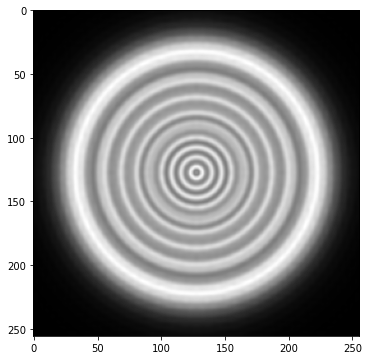

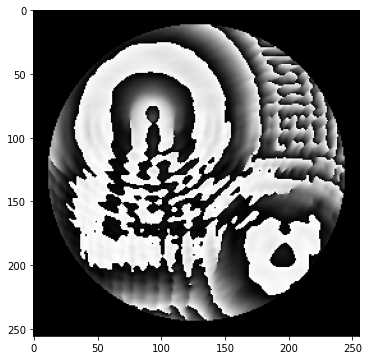

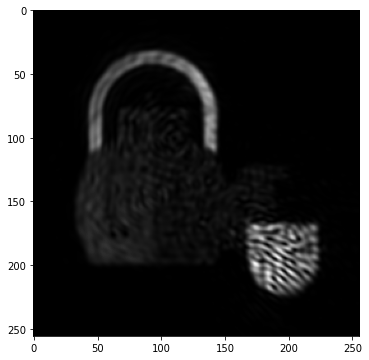

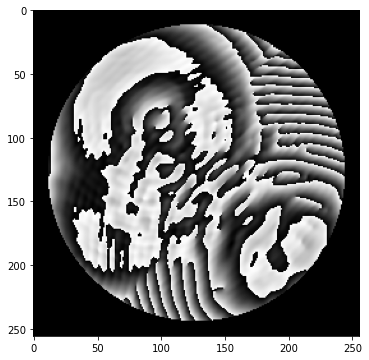

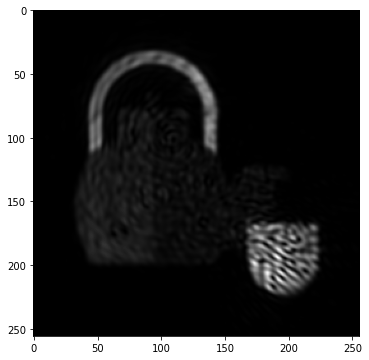

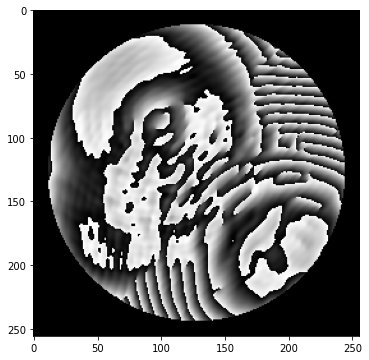

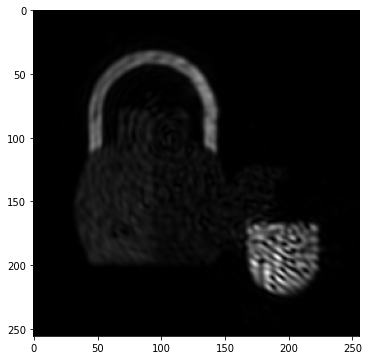

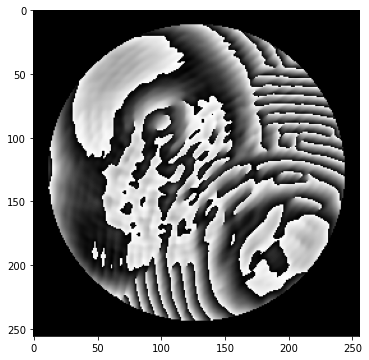

True

In [30]:
loss_record = []
psnr_log = []
ssim_log = []
for step_s in range(200):
  input_plane = light_img*np.exp(1j*in_plane_phase)
  pressure = angular_spectrumCW(input_plane, forward_h)

  loss_record.append(loss_func())

  retain_phase = tf.math.angle(pressure).numpy()
  at_target = target_img*np.exp(1j*retain_phase)
  back_pressure = tf.math.conj(angular_spectrumCW(tf.math.conj(at_target), forward_h))

  phaseK = tf.math.angle(back_pressure)
  in_plane_phase = phaseK.numpy()
  in_plane_phase = np.where(input_int  == 0, 0, in_plane_phase)

  if (step_s%50)==0:
    prop_inten = pressure * tf.math.conj(pressure)
    prop_inten = tf.dtypes.cast(prop_inten, tf.float64)
    imgs = [
      amp_abs(prop_inten.numpy()), 
      phaser_draw(in_plane_phase)
    ]
    show_imgs(imgs)

exporting_phase = phaser_draw(in_plane_phase)
all_loss_to_csv = np.array(loss_record)
np.savetxt('test_image_' + image_number + '_loss_record_IASA.csv', np.array(loss_record), delimiter=',')
cv2.imwrite('test_image_' + image_number + '_phase_ex_IASA.png', exporting_phase)